## **Install conda and rdkit**

In [11]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2024-11-08 23:34:55--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:20f1, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.3’

Miniconda3-py37_4.8 100%[===================>]  81.12M   290MB/s    in 0.3s    

2024-11-08 23:34:55 (290 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.3’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003


## **Load bioactivity data**

In [12]:
import pandas as pd

In [13]:
df = pd.read_csv('bioactivity_data_preprocessed.csv')

In [16]:
!pip install rdkit

     |████████████████████████████████| 29.5 MB 34.7 MB/s 


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [17]:
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [18]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [19]:
df_lipinski = lipinski(df.canonical_smiles)

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [20]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,796.992,1.0006,10.0,14.0
1,507.428,4.3004,2.0,3.0
2,4331.996,-9.9754,59.0,60.0
3,574.747,3.6599,2.0,5.0
4,542.036,3.9395,1.0,10.0
5,430.585,5.7974,1.0,4.0


In [21]:
df

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL4763715,C[C@H]1O[C@@](O)(O[C@H]2CC[C@@]3(C)[C@@H](CC[C...,1700.00
1,CHEMBL5270175,O=C(NC(Cc1ccccc1)C(=O)N1CCC(O)(c2ccc(Br)cc2)CC...,700.00
2,CHEMBL5283406,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(...,3350.00
3,CHEMBL91704,CN1CCN(C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@H](/C=C...,1.48
4,CHEMBL217092,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,5100.00
5,CHEMBL5278230,C=C(C=O)[C@H]1CC=C2[C@H](OC(=O)/C(C)=C/CCCCCCC...,18100.00


Now, let's combine the 2 DataFrame

In [22]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [23]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL4763715,C[C@H]1O[C@@](O)(O[C@H]2CC[C@@]3(C)[C@@H](CC[C...,1700.00,796.992,1.0006,10.0,14.0
1,CHEMBL5270175,O=C(NC(Cc1ccccc1)C(=O)N1CCC(O)(c2ccc(Br)cc2)CC...,700.00,507.428,4.3004,2.0,3.0
2,CHEMBL5283406,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(...,3350.00,4331.996,-9.9754,59.0,60.0
3,CHEMBL91704,CN1CCN(C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@H](/C=C...,1.48,574.747,3.6599,2.0,5.0
4,CHEMBL217092,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,5100.00,542.036,3.9395,1.0,10.0
5,CHEMBL5278230,C=C(C=O)[C@H]1CC=C2[C@H](OC(=O)/C(C)=C/CCCCCCC...,18100.00,430.585,5.7974,1.0,4.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [37]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        pIC50_value = -np.log10(i * (10**-9))  # Example calculation for pIC50
        pIC50.append(pIC50_value)

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x


Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [25]:
df_combined.standard_value.describe()

,standard_value
count,6.000000
mean,4825.246667
std,6760.539473
min,1.480000
25%,950.000000
50%,2525.000000
75%,4662.500000
max,18100.000000


In [26]:
-np.log10( (10**-9)* 100000000 )

1.0

In [27]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [33]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x


We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [34]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL4763715,C[C@H]1O[C@@](O)(O[C@H]2CC[C@@]3(C)[C@@H](CC[C...,796.992,1.0006,10.0,14.0,1700.00
1,CHEMBL5270175,O=C(NC(Cc1ccccc1)C(=O)N1CCC(O)(c2ccc(Br)cc2)CC...,507.428,4.3004,2.0,3.0,700.00
2,CHEMBL5283406,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(...,4331.996,-9.9754,59.0,60.0,3350.00
3,CHEMBL91704,CN1CCN(C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@H](/C=C...,574.747,3.6599,2.0,5.0,1.48
4,CHEMBL217092,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,542.036,3.9395,1.0,10.0,5100.00
5,CHEMBL5278230,C=C(C=O)[C@H]1CC=C2[C@H](OC(=O)/C(C)=C/CCCCCCC...,430.585,5.7974,1.0,4.0,18100.00


In [35]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,6.000000
mean,4825.246667
std,6760.539473
min,1.480000
25%,950.000000
50%,2525.000000
75%,4662.500000
max,18100.000000


In [38]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL4763715,C[C@H]1O[C@@](O)(O[C@H]2CC[C@@]3(C)[C@@H](CC[C...,796.992,1.0006,10.0,14.0,5.769551
1,CHEMBL5270175,O=C(NC(Cc1ccccc1)C(=O)N1CCC(O)(c2ccc(Br)cc2)CC...,507.428,4.3004,2.0,3.0,6.154902
2,CHEMBL5283406,CC[C@H](C)[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCC(...,4331.996,-9.9754,59.0,60.0,5.474955
3,CHEMBL91704,CN1CCN(C(=O)N[C@@H](Cc2ccccc2)C(=O)N[C@H](/C=C...,574.747,3.6599,2.0,5.0,8.829738
4,CHEMBL217092,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,542.036,3.9395,1.0,10.0,5.292430
5,CHEMBL5278230,C=C(C=O)[C@H]1CC=C2[C@H](OC(=O)/C(C)=C/CCCCCCC...,430.585,5.7974,1.0,4.0,4.742321


In [39]:
df_final.pIC50.describe()

,pIC50
count,6.000000
mean,6.043983
std,1.444368
min,4.742321
25%,5.338061
50%,5.622253
75%,6.058564
max,8.829738


### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [41]:
print(df_final.columns)


Index(['molecule_chembl_id', 'canonical_smiles', 'MW', 'LogP', 'NumHDonors',
       'NumHAcceptors', 'pIC50'],
      dtype='object')


In [44]:
# Define a function to classify bioactivity based on pIC50 values
def classify_bioactivity(row):
    if row['pIC50'] >= 6:
        return 'active'
    elif row['pIC50'] < 5:
        return 'inactive'
    else:
        return 'intermediate'

# Apply the function to create the bioactivity_class column in df_final
df_final['bioactivity_class'] = df_final.apply(classify_bioactivity, axis=1)

# Filter out rows with 'intermediate' bioactivity_class
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']




---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [45]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

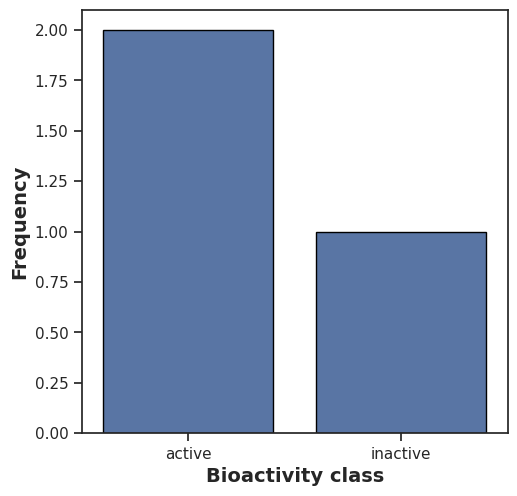

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

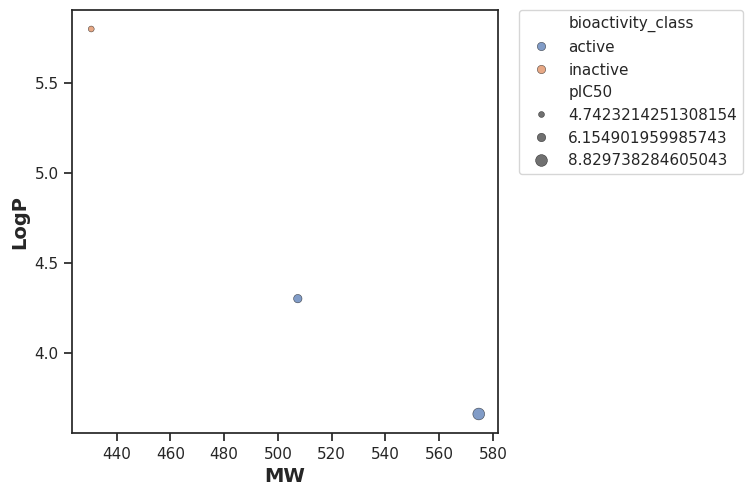

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

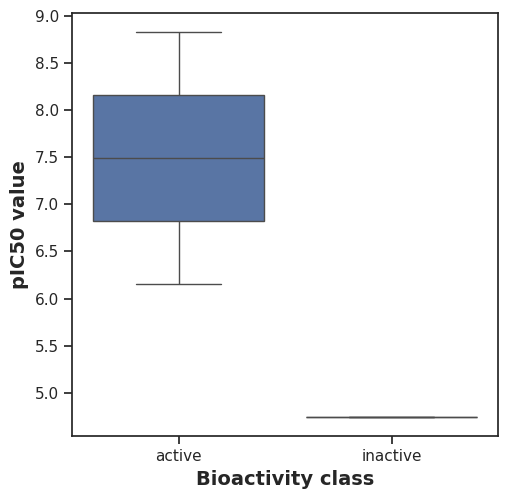

In [48]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [49]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [50]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,2.0,0.666667,0.05,Same distribution (fail to reject H0)


#### **MW**

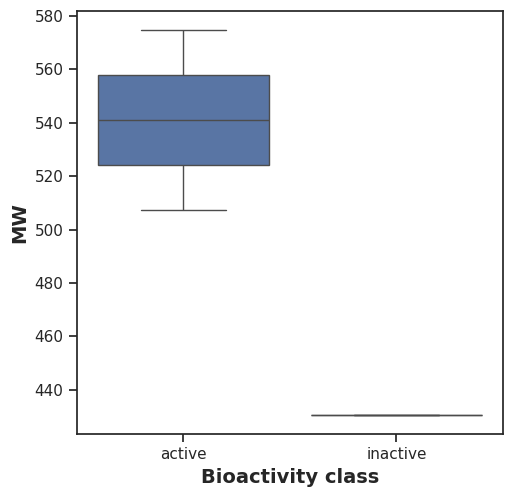

In [51]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [52]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2.0,0.666667,0.05,Same distribution (fail to reject H0)


#### **LogP**

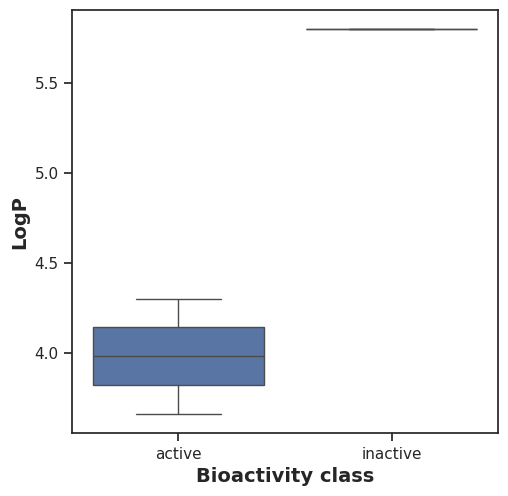

In [53]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [54]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,0.0,0.666667,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

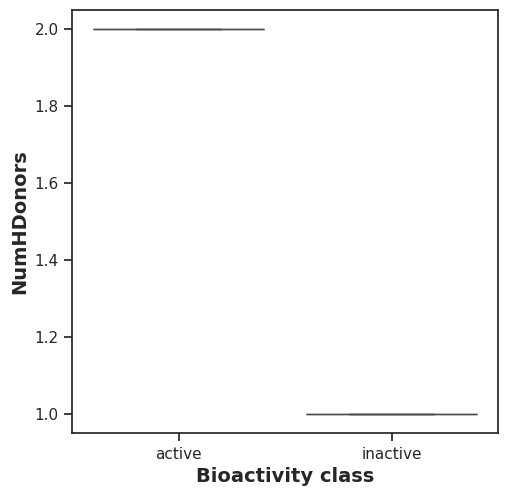

In [55]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [56]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,2.0,0.4795,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

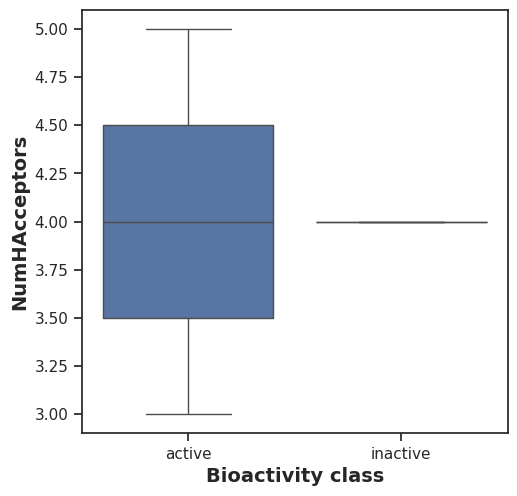

In [57]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [58]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1.0,1.0,0.05,Same distribution (fail to reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

## **Zip files**

In [59]:
! zip -r results.zip . -i *.csv *.pdf

  adding: plot_MW_vs_LogP.pdf (deflated 33%)
  adding: bioactivity_data_preprocessed.csv (deflated 68%)
  adding: mannwhitneyu_LogP.csv (deflated 17%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: mannwhitneyu_MW.csv (deflated 15%)
  adding: plot_MW.pdf (deflated 38%)
  adding: plot_LogP.pdf (deflated 40%)
  adding: plot_ic50.pdf (deflated 36%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: mannwhitneyu_pIC50.csv (deflated 17%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
  adding: plot_bioactivity_class.pdf (deflated 39%)
